Dataset shape: (12000, 6)
Top 10 suspicious customers:
    customer_id  iso_score  lof_score  combined_score
964    CUST0965  -0.166667  -0.166667       -0.166667
20     CUST0021   0.000000  -0.500000       -0.250000
325    CUST0326  -0.166667  -0.333333       -0.250000
331    CUST0332   0.000000  -0.500000       -0.250000
417    CUST0418  -0.166667  -0.333333       -0.250000
65     CUST0066  -0.833333   0.166667       -0.333333
363    CUST0364  -0.333333  -0.500000       -0.416667
803    CUST0804  -0.333333  -0.500000       -0.416667
949    CUST0950  -0.333333  -0.500000       -0.416667
208    CUST0209  -0.500000  -0.333333       -0.416667
✅ Saved top 50 suspicious customers to C:\Users\Hp\WattAudit++\data\top50_suspicious_customers.csv


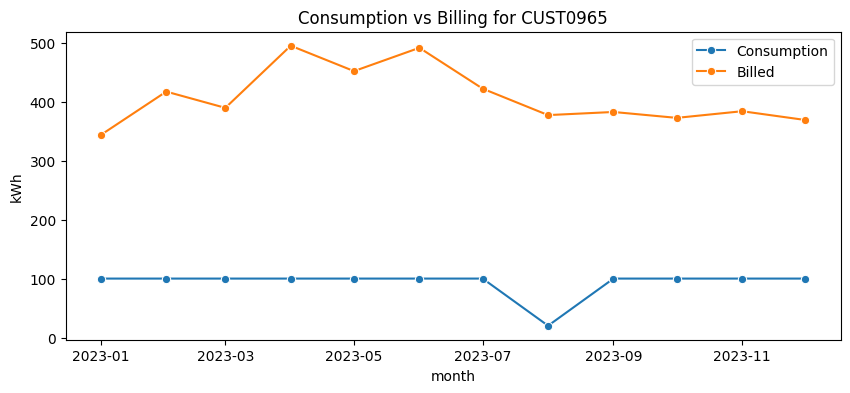

In [2]:
# improved_anomaly_detection.ipynb

import os
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------------------
# Setup
# ----------------------------
BASE_DIR = os.path.dirname(os.path.dirname(os.path.abspath("__file__")))
DATA_DIR = os.path.join(BASE_DIR, "data")

# Load dummy dataset
df = pd.read_csv(os.path.join(DATA_DIR, "dummy_billing_dataset.csv"), parse_dates=["month"])
df = df.sort_values(["customer_id","month"]).reset_index(drop=True)

print("Dataset shape:", df.shape)
df.head()

# ----------------------------
# Feature Engineering
# ----------------------------

# Rolling stats per customer
df["rolling_mean_3"] = df.groupby("customer_id")["consumption_kwh"].rolling(3, min_periods=1).mean().reset_index(0,drop=True)
df["rolling_std_3"] = df.groupby("customer_id")["consumption_kwh"].rolling(3, min_periods=1).std().reset_index(0,drop=True).fillna(0)

# Percent change month to month
df["pct_change"] = df.groupby("customer_id")["consumption_kwh"].pct_change().fillna(0)

# Ratio billed vs consumed
df["billed_ratio"] = df["billed_kwh"] / df["consumption_kwh"].replace(0,np.nan)
df["billed_ratio"] = df["billed_ratio"].fillna(0)

# Seasonality
df["month_num"] = df["month"].dt.month
df["month_sin"] = np.sin(2*np.pi*df["month_num"]/12)
df["month_cos"] = np.cos(2*np.pi*df["month_num"]/12)

# Peer comparison (category+feeder+month)
peer = df.groupby(["consumer_category","feeder_id","month_num"])["consumption_kwh"].median().reset_index().rename(columns={"consumption_kwh":"peer_median"})
df = df.merge(peer, on=["consumer_category","feeder_id","month_num"], how="left")
df["peer_ratio"] = df["consumption_kwh"] / df["peer_median"].replace(0, np.nan)
df["peer_ratio"] = df["peer_ratio"].fillna(0)

# Final feature set
features = ["consumption_kwh","billed_kwh","rolling_mean_3","rolling_std_3",
            "pct_change","billed_ratio","month_sin","month_cos","peer_ratio"]

X = df[features].fillna(0)

# ----------------------------
# Isolation Forest
# ----------------------------
iso = IsolationForest(n_estimators=200, contamination=0.05, random_state=42)
df["iso_score"] = -iso.fit_predict(X)  # -1 = anomaly, 1 = normal

# ----------------------------
# Local Outlier Factor (LOF)
# ----------------------------
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
df["lof_score"] = -lof.fit_predict(X)  # -1 = anomaly

# ----------------------------
# Aggregate to customer level
# ----------------------------
cust_scores = df.groupby("customer_id")[["iso_score","lof_score"]].mean().reset_index()

# Simple ensemble = average of both
cust_scores["combined_score"] = cust_scores[["iso_score","lof_score"]].mean(axis=1)

# Rank customers
cust_scores = cust_scores.sort_values("combined_score", ascending=False)
top50 = cust_scores.head(50)

print("Top 10 suspicious customers:")
print(top50.head(10))

# Save for dashboard if needed
out_file = os.path.join(DATA_DIR, "top50_suspicious_customers.csv")
top50.to_csv(out_file, index=False)
print(f"✅ Saved top 50 suspicious customers to {out_file}")

# ----------------------------
# Visualization Example
# ----------------------------
cust_id = top50.iloc[0]["customer_id"]
cust_data = df[df["customer_id"]==cust_id]

plt.figure(figsize=(10,4))
sns.lineplot(data=cust_data, x="month", y="consumption_kwh", marker="o", label="Consumption")
sns.lineplot(data=cust_data, x="month", y="billed_kwh", marker="o", label="Billed")
plt.title(f"Consumption vs Billing for {cust_id}")
plt.ylabel("kWh")
plt.legend()
plt.show()
